## Need to get accurate detection working.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()

class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

Use the code from `diffimTests.py`.

In [9]:
import diffimTests as dit
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, offset=[0,0], psf_yvary_factor=0., 
                         varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         theta1=0., theta2=-45., im2background=0., n_sources=50, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)

print dit.computeClippedImageStats(testObj.im1.im)
print dit.computeClippedImageStats(testObj.im2.im)
print dit.computeClippedImageStats(testObj.im1.var)
print dit.computeClippedImageStats(testObj.im2.var)

(0.058941207521673616, 17.142582277831181, -74.0, 1741.5550996425638)
(0.16640941424314851, 17.212254472642801, -82.0, 1169.0572762553779)
(300.05894120752163, 17.142582277831185, 226.0, 2041.5550996425638)
(300.16640941424311, 17.212254472642801, 218.0, 1469.0572762553779)


In [10]:
src = testObj.runTest(returnSources=True)

In [11]:
changedCentroid = np.array(testObj.centroids[testObj.changedCentroidInd, :])
print changedCentroid

#print src['AL'][['base_NaiveCentroid_x', 'base_NaiveCentroid_y', 'base_PsfFlux_fluxSigma', 'base_PsfFlux_flag']]
print src['ALstack'][['base_NaiveCentroid_x', 'base_NaiveCentroid_y', 'base_PsfFlux_fluxSigma', 'base_PsfFlux_flag']]
print src['ZOGY'][['base_NaiveCentroid_x', 'base_NaiveCentroid_y', 'base_PsfFlux_fluxSigma', 'base_PsfFlux_flag']]
# For SZOGY, the correct flux measurement is PeakLikelihoodFlux
print src['SZOGY'][['base_NaiveCentroid_x', 'base_NaiveCentroid_y', 'base_PeakLikelihoodFlux_fluxSigma', 'base_PsfFlux_flag']]

[[   245.89925013    279.36159005   1423.89964966   2923.89964966]
 [   287.15359438    287.4644825   11199.22125222  12799.22125222]
 [   262.66886207    301.46927489  20097.66173206  21897.66173206]
 [   305.71844991    258.5881023   27152.92647256  29152.92647256]
 [   286.8634569     311.26461378  26439.91024586  28639.91024586]
 [   193.35871751    245.82202312  16949.74839209  19349.74839209]
 [   293.52593604    203.14457926   4226.31645367   6826.31645367]
 [   220.82192365    196.83656518  14224.08558878  17024.08558878]]
   base_NaiveCentroid_x  base_NaiveCentroid_y  base_PsfFlux_fluxSigma base_PsfFlux_flag
2            220.281251            196.981653               49.316532             False
3            293.161952            203.164991               40.427573             False
4            193.111072            246.116698               51.349183             False
5            245.311693            278.280909               36.556438             False
6            286.328456

In [13]:
dist = np.sqrt(np.add.outer(src['ALstack'].base_NaiveCentroid_x, -changedCentroid[:, 0])**2. + \
               np.add.outer(src['ALstack'].base_NaiveCentroid_y, -changedCentroid[:, 1])**2.) # in pixels
print dist
matches = np.where(dist <= 1.5)
print matches
true_pos = len(matches[0])
false_neg = changedCentroid.shape[0] - len(matches[0])
false_pos = src['ALstack'].shape[0] - len(matches[0])
print true_pos, false_neg, false_pos

[[  86.27129218  112.51245572  112.75802692  105.33218657  132.26407373
    55.76920765   73.50350712    0.55980141]
 [  89.66428865   84.51333985  102.92502483   56.82769488  108.28296019
   108.53712704    0.36455619   72.6163111 ]
 [  62.38441002  102.7308879    88.89428524  113.29588484  114.16549669
     0.38491776  109.22338553   56.53691539]
 [   1.23007945   42.83786577   28.96500722   63.53568224   53.05161529
    61.25921085   89.27531157   85.04663371]
 [  41.37089973    1.06530979   27.15679004   35.34382713   23.13250012
   102.1471471    85.29792777  112.37042659]
 [  27.25813503   28.38835371    0.50375892   60.81270374   26.58293607
    88.3811256   102.8637413   112.24852294]]
(array([0, 1, 2, 3, 4, 5]), array([7, 6, 5, 0, 1, 2]))
6 2 0


In [14]:
dist = np.sqrt(np.add.outer(src['SZOGY'].base_NaiveCentroid_x, -changedCentroid[:, 0])**2. + \
               np.add.outer(src['SZOGY'].base_NaiveCentroid_y, -changedCentroid[:, 1])**2.) # in pixels
print dist
matches = np.where(dist <= 1.5)
true_pos = len(matches[0])
false_neg = changedCentroid.shape[0] - len(matches[0])
false_pos = src['SZOGY'].shape[0] - len(matches[0])
print true_pos, false_neg, false_pos

[[  87.1614004   113.32639617  113.6381244   105.99553816  133.11320735
    56.44876739   73.76625309    1.0290128 ]
 [  89.72609575   84.63301002  103.01996376   56.9697138   108.40383698
   108.50752351    0.46240337   72.51956138]
 [  63.01859887  103.22988262   89.61686402  113.49020423  114.83512621
     0.83279673  108.87667845   55.64886005]
 [  62.89471505   34.41204922   60.66913923    0.79785649   56.20541253
   112.4034766    56.15556602  104.1820237 ]
 [   0.36793809   42.00708849   27.96577873   63.107761     52.05484481
    62.23477061   89.51881442   85.94558632]
 [  41.8352027     0.42471634   28.29405447   34.06419507   24.20371769
   102.33806184   84.16865896  111.90476193]
 [  27.07271371   28.51716987    0.71057056   60.89112055   26.79518961
    88.17580008  102.8405755   112.09670121]
 [  51.17514688   23.61167225   25.29790168   56.01825006    0.81024711
   113.36872644  108.16370805  131.54449663]
 [ 222.58393332  180.5509547   203.10409714  170.10780572  178.3

In [15]:
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, offset=[0,0], psf_yvary_factor=0., 
                         varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         theta1=0., theta2=-45., im2background=0., n_sources=50, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)

det = testObj.runTest()
print det

{'ZOGY': {'FP': 0, 'FN': 0, 'TP': 8}, 'ALstack': {'FP': 0, 'FN': 2, 'TP': 6}, 'SZOGY': {'FP': 1, 'FN': 0, 'TP': 8}}


Try some real tests!

In [10]:
# Default 10 sources with same flux
def runTest(flux, seed=66, sky=300., n_sources=50, n_varSources=10):
    sky = 300.
    testObj = dit.DiffimTest(imSize=(512,512), sky=sky, offset=[0,0], psf_yvary_factor=0., 
                             varSourceChange=np.repeat(flux, n_varSources),
                             theta1=0., theta2=-45., im2background=0., n_sources=n_sources, 
                             sourceFluxRange=(500,30000), seed=seed, psfSize=13)
    det = testObj.runTest(subtractMethods=['ALstack', 'ZOGY', 'ZOGY_S']) #, 'AL'])
    det['flux'] = flux
    return det

#testResults = [runTest(f, seed) for f in [1500, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000] for \
#              seed in [66, 67, 68, 69, 70]]

inputs = [(f, seed) for f in np.arange(1500, 3001, 100) for seed in np.arange(66, 86, 1)]
print len(inputs)
testResults = Parallel(n_jobs=num_cores)(delayed(runTest)(i[0], i[1]) for i in inputs)

320


FN: {'ZOGY': 1.0718749999999999, 'ALstack': 2.1343749999999999, 'SZOGY': 0.83750000000000002}
FP: {'ZOGY': 0.34999999999999998, 'ALstack': 2.2749999999999999, 'SZOGY': 0.19062499999999999}
TP: {'ZOGY': 8.9281249999999996, 'ALstack': 7.8656249999999996, 'SZOGY': 9.1624999999999996}


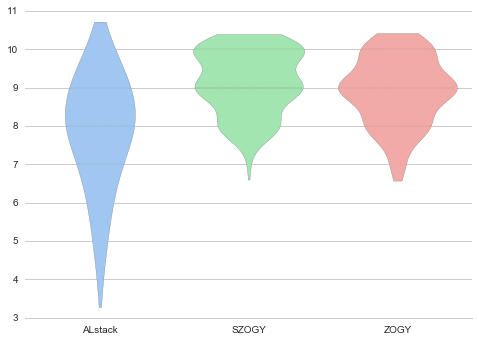

In [13]:
tr = testResults
FN = {key: np.array([t[key]['FN'] for t in tr]).mean() for key in ['ALstack', 'ZOGY', 'SZOGY']}
FP = {key: np.array([t[key]['FP'] for t in tr]).mean() for key in ['ALstack', 'ZOGY', 'SZOGY']}
TP = {key: np.array([t[key]['TP'] for t in tr]).mean() for key in ['ALstack', 'ZOGY', 'SZOGY']}
print 'FN:', FN
print 'FP:', FP
print 'TP:', TP

FN = pd.DataFrame({key: np.array([t[key]['FN'] for t in tr]) for key in ['ALstack', 'ZOGY', 'SZOGY']})
FP = pd.DataFrame({key: np.array([t[key]['FP'] for t in tr]) for key in ['ALstack', 'ZOGY', 'SZOGY']})
TP = pd.DataFrame({key: np.array([t[key]['TP'] for t in tr]) for key in ['ALstack', 'ZOGY', 'SZOGY']})
#sizeme(FN)

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

sns.violinplot(data=TP, inner="quart", cut=True, linewidth=0.3, bw=0.5)
sns.despine(left=True)

In [6]:
inputs = [(f, seed) for f in np.repeat(1500, 10) for seed in np.arange(66, 86, 1)]
print len(inputs)
testResults2 = Parallel(n_jobs=num_cores)(delayed(runTest)(i[0], i[1]) for i in inputs)

200


FN: {'ZOGY': 1.3, 'ALstack': 3.5, 'SZOGY': 0.84999999999999998}
FP: {'ZOGY': 0.69999999999999996, 'ALstack': 0.59999999999999998, 'SZOGY': 0.29999999999999999}
TP: {'ZOGY': 8.6999999999999993, 'ALstack': 6.5, 'SZOGY': 9.1500000000000004}


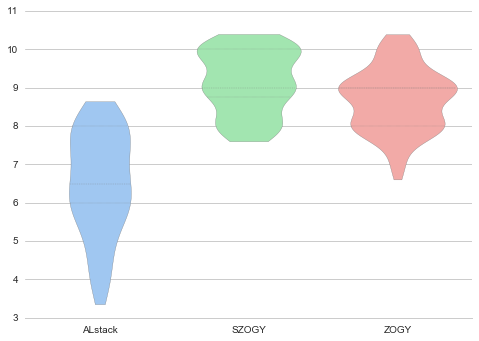

In [14]:
tr = testResults2
FN = {key: np.array([t[key]['FN'] for t in tr]).mean() for key in ['ALstack', 'ZOGY', 'SZOGY']}
FP = {key: np.array([t[key]['FP'] for t in tr]).mean() for key in ['ALstack', 'ZOGY', 'SZOGY']}
TP = {key: np.array([t[key]['TP'] for t in tr]).mean() for key in ['ALstack', 'ZOGY', 'SZOGY']}
print 'FN:', FN
print 'FP:', FP
print 'TP:', TP

FN = pd.DataFrame({key: np.array([t[key]['FN'] for t in tr]) for key in ['ALstack', 'ZOGY', 'SZOGY']})
FP = pd.DataFrame({key: np.array([t[key]['FP'] for t in tr]) for key in ['ALstack', 'ZOGY', 'SZOGY']})
TP = pd.DataFrame({key: np.array([t[key]['TP'] for t in tr]) for key in ['ALstack', 'ZOGY', 'SZOGY']})
#sizeme(FN)

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

sns.violinplot(data=TP, inner="quart", cut=True, linewidth=0.3, bw=0.5)
sns.despine(left=True)

In [15]:
inputs = [(f, seed) for f in np.arange(1000, 2000, 25) for seed in np.arange(66, 86, 1)]
print len(inputs)
testResults3 = Parallel(n_jobs=num_cores)(delayed(runTest)(i[0], i[1]) for i in inputs)

800


FN: {'ZOGY': 1.4125000000000001, 'ALstack': 3.9674999999999998, 'SZOGY': 1.0774999999999999}
FP: {'ZOGY': 0.74875000000000003, 'ALstack': 0.77124999999999999, 'SZOGY': 0.46500000000000002}
TP: {'ZOGY': 8.5875000000000004, 'ALstack': 6.0324999999999998, 'SZOGY': 8.9224999999999994}


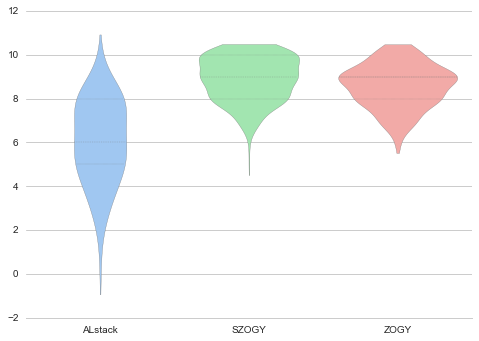

In [16]:
tr = testResults3
FN = {key: np.array([t[key]['FN'] for t in tr]).mean() for key in ['ALstack', 'ZOGY', 'SZOGY']}
FP = {key: np.array([t[key]['FP'] for t in tr]).mean() for key in ['ALstack', 'ZOGY', 'SZOGY']}
TP = {key: np.array([t[key]['TP'] for t in tr]).mean() for key in ['ALstack', 'ZOGY', 'SZOGY']}
print 'FN:', FN
print 'FP:', FP
print 'TP:', TP

FN = pd.DataFrame({key: np.array([t[key]['FN'] for t in tr]) for key in ['ALstack', 'ZOGY', 'SZOGY']})
FP = pd.DataFrame({key: np.array([t[key]['FP'] for t in tr]) for key in ['ALstack', 'ZOGY', 'SZOGY']})
TP = pd.DataFrame({key: np.array([t[key]['TP'] for t in tr]) for key in ['ALstack', 'ZOGY', 'SZOGY']})
#sizeme(FN)

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

sns.violinplot(data=TP, inner="quart", cut=True, linewidth=0.3, bw=0.5)
sns.despine(left=True)